In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0, '../src')
import rebound
import numpy as np
import horizons_api
import tools
import warnings
warnings.filterwarnings("ignore")
import scipy.signal as signal

import run_reb
import tools
def prop_calc(objname, filename='Single',objdes=None):
    
    """
    Calculate prop elements of small celestial bodies from simulation archive files, using a given file list of names.

    Parameters:
        objname (int): Name/designation of the celestial body in the dataset.
        filename (str): Name of the file containing the list of names, and the directory containing the arxhive.bin files. 

    Returns:
        outputs: A list containing calculated proper elements, or  
        - objname
        - Observed Eccentricity
        - Observed Sin(Inclination)
        - Calculated Proper Eccentricity
        - Calculated Proper Sin(Inclination)
        - Calculated Proper Semimajor Axis 
        - Running Block Proper Elements [Calc Proper Ecc, Calc Proper Sin(Inc), Calc Proper SMA]
        
        The Running Block calculations are used to calculate a mean error for the proper elements. The default run will be a 100 Myr integration, with running blocks from 0-20,10-30,...80-100 Myr, producing 9 running blocks total. So your default run will produce an outputs list consisting of 33 values total.  
        
        If an error occurs in the code, then outputs is instead returned as [objname,0,0,0,0,0,0,0].
        
    """    
#    print(objname)
    try:       
        fullfile = '../data/'+filename+'/'+str(objname)+'/archive.bin'
        print(fullfile)
        archive = rebound.Simulationarchive(fullfile)
        
        try:
            earth = archive[0].particles['earth']
            small_planets_flag = True
        except:
            small_planets_flag = False
        
        nump = len(archive[0].particles)
        flag, a_init, e_init, inc_init, lan_init, aop_init, M_init, t_init = tools.read_sa_for_sbody(sbody = str(objname), archivefile=fullfile,nclones=0,tmin=0.,tmax=archive[-1].t)

        
    except Exception as error:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        line_number = exc_tb.tb_lineno

        error_message = f"An error occurred in {fname} at line {line_number}: {error}"
    
        # Print the error message
        print(error_message)
        return [objname,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    p_init = np.sin(inc_init)*np.sin(lan_init)
    q_init = np.sin(inc_init)*np.cos(lan_init)
    h_init = (e_init)*np.sin(lan_init+aop_init)
    k_init = (e_init)*np.cos(lan_init+aop_init)
    #print(t_init)
    
    try:
        dt = t_init[1]
    
        n = len(h_init)
        if n < 10001:
            print(n)
        freq = np.fft.rfftfreq(n,d=dt)
        rev = 1296000
    
        #particle eccentricity vectors
        Yh= np.fft.rfft(h_init)
        Yk = np.fft.rfft(k_init)
        Yp= np.fft.rfft(p_init)
        Yq = np.fft.rfft(q_init)
        Ya_f = np.fft.rfft(a_init)
        
        Yp[0]=0
        Yq[0]=0
        #Yh[0]=0
        #Yk[0]=0
      
        imax = len(Yp)
        #disregard antyhing with a period shorter than 5000 years
        freqlim = 1./2000.
        #disregard frequencies for which any planet has power at higher than 10% the max
        pth = 0.25
           
        #print(hk_ind,pq_ind)
        pYh = np.abs(Yh)**2
        pYk = np.abs(Yk)**2
        pYp = np.abs(Yp)**2
        pYq = np.abs(Yq)**2
        
        #make copies of the FFT outputs
        Yp_f = Yp.copy()
        Yq_f = Yq.copy()
        Yh_f = Yh.copy()
        Yk_f = Yk.copy()
      
        gind = np.argmax(np.abs(Yh[1:]))+1    
        sind = np.argmax(np.abs(Yp[1:]))+1
        g = freq[gind]  
        s = freq[sind]
        
        spread = 1
        while int(1/(freq[gind+spread]-freq[gind-spread])/dt) > 2500:
            spread = spread+1
        
        freq_dist_lim = 1
        while int(1/(freq[gind+freq_dist_lim]-freq[gind-freq_dist_lim])/dt) > 1250:
            freq_dist_lim = freq_dist_lim+1

    except:
        return [objname,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    # g1s1 -> g4s4 taken from Murray and Dermott SSD Table 7.1
    g1 = 5.46326/rev
    s1 = -5.20154/rev
    g2 = 7.34474/rev
    s2 = -6.57080/rev
    g3 = 17.32832/rev
    s3 = -18.74359/rev
    g4 = 18.00233/rev
    s4 = -17.63331/rev
    
    # g5s6 -> g8s8 taken directly from OrbFit software.
    g5 = 4.25749319/rev
    g6 = 28.24552984/rev
    g7 = 3.08675577/rev
    g8 = 0.67255084/rev
    s6 = -26.34496354/rev
    s7 = -2.99266093/rev
    s8 = -0.69251386/rev

    #print(g,s,g6,s6)
    z1 = abs(g+s-g6-s6)
    z2 = abs(g+s-g5-s7)
    z3 = abs(g+s-g5-s6)
    z4 = abs(g-2*g6+g5)
    z5 = abs(g-2*g6+g7)
    z6 = abs(s-s6-g5+g6)
    z7 = abs(g-3*g6+2*g5)
    z8 = abs(2*(g-g6)+s-s6)
    z9 = abs(3*(g-g6)+s-s6)
    
    gfreqs = [g1,g2,g3,g4,g5,g6,g7,g8]
    sfreqs = [s1,s2,s3,s4,s6,s7,s8]
    zfreqs = [z1,z2,z3,z4,z5,z6,z8,z9]
    
    gfreqs =[g5,g6,g7,g8,z1,z2,z3,z4,z5,z8,z9]
    sfreqs = [s6,s7,s8,z1,z2,z3,z6,z8,z9]
    
    if small_planets_flag:
        freq1 = [g1,g2,g3,g4,g5,g6,g7,g8,z1,z2,z3,z4,z5,z7,z8,z9]
        freq2 = [s1,s2,s3,s4,s6,s7,s8,z1,z2,z3,z6,z8,z9]
    else:
        freq1 = [g5,g6,g7,g8,z1,z2,z3,z4,z5,z7,z8,z9]
        freq2 = [s6,s7,s8,z1,z2,z3,z6,z8,z9]
    
    secresind1 = []
    secresind2 = []
    for i in freq1:
        try:
            secresind1.append(np.where(freq>=i)[0][0])
        except:
            continue
    for i in freq2:
        try:
            secresind2.append(np.where(freq>=i)[0][0])
        except:
            continue


    limit_ind = np.where(freq >= freqlim)[0]

    for i in range(len(secresind1)):
        if secresind1[i] == gind:
            continue
        if abs(secresind1[i] - gind) < freq_dist_lim:
            continue

        if spread > 0:
            Yh_f[secresind1[i]-spread:secresind1[i]+spread] = 0
            Yk_f[secresind1[i]-spread:secresind1[i]+spread] = 0
        else:
            Yh_f[secresind1[i]] = 0
            Yk_f[secresind1[i]] = 0
            
    for i in range(len(secresind2)):
        if secresind2[i] == sind:
            continue
        if abs(secresind2[i] - sind) < freq_dist_lim:
            continue

        if spread > 0:
            Yp_f[secresind2[i]-spread:secresind2[i]+spread] = 0
            Yq_f[secresind2[i]-spread:secresind2[i]+spread] = 0
        else:
            Yp_f[secresind2[i]] = 0
            Yq_f[secresind2[i]] = 0

    Yp_f[limit_ind] = 0
    Yq_f[limit_ind] = 0
    Yk_f[limit_ind] = 0
    Yh_f[limit_ind] = 0
    Ya_f[limit_ind] = 0
    
    p_f = np.fft.irfft(Yp_f,len(p_init))
    q_f = np.fft.irfft(Yq_f,len(q_init))
    h_f = np.fft.irfft(Yh_f,len(h_init))
    k_f = np.fft.irfft(Yk_f,len(k_init))
    a_f = np.fft.irfft(Ya_f,len(a_init))

    sini_f = np.sqrt(p_f*p_f + q_f*q_f)
    ecc_f = np.sqrt(h_f*h_f + k_f*k_f) 

    return [freq,pYh,pYk,pYp,pYq,gfreqs,sfreqs,zfreqs,sini_f,ecc_f]

In [76]:
#objname = '2012 HZ84'
#freq,pYh,pYk,pYp,pYq,gfreqs,sfreqs,zfreqs,sini,ecc = prop_calc(objname, filename='TNOs_high',objdes=None)

objname = '2006 UO321'
objname = '2014 US277'
vals = prop_calc(objname, filename='Single',objdes=None)

../data/Single/2014 US277/archive.bin


100001


Text(0.5, 1.0, 'Filtered Ecc')

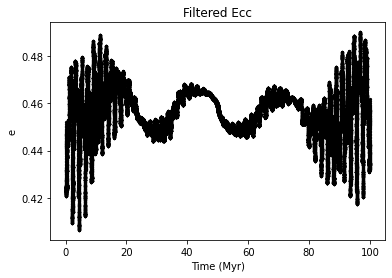

In [79]:
t = np.arange(0,1e8,1e8/100001)
print(len(vals[-1]))
#print(len(vals[-1]))
plt.scatter(t/1e6,vals[-1],color='k',s=5)
plt.xlabel('Time (Myr)')
plt.ylabel('e')
plt.title('Filtered Ecc')

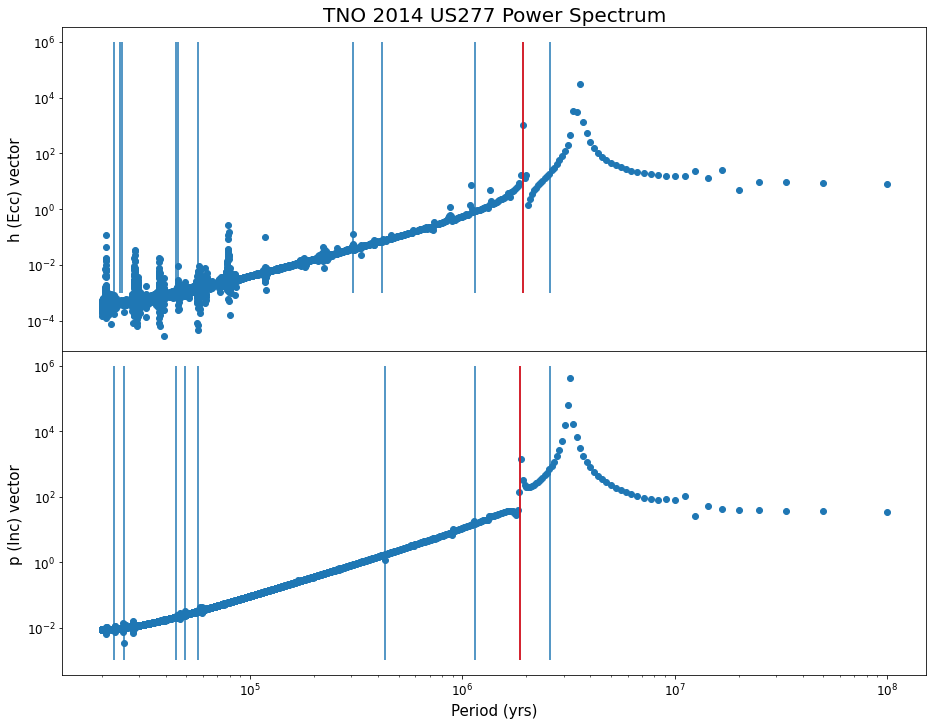

In [82]:
fig = plt.figure(figsize=(12,9))
gs = fig.add_gridspec(2,left=0, right=1, bottom=0, top=1,
                      wspace=0, hspace=0)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex=ax1)

ax1.scatter(1/freq,pYh)
ax2.scatter(1/freq,pYp)
ax1.vlines(1/np.array(gfreqs),1e-3,1e6)
#ax[0].vlines(1/np.array(zfreqs),1e-3,1e6)
ax2.vlines(1/np.array(np.abs(sfreqs)),1e-3,1e6)

ax1.vlines(1/np.array(gfreqs[3]),1e-3,1e6,colors='r')
#ax[0].vlines(1/np.array(zfreqs),1e-3,1e6)
ax2.vlines(1/np.array(np.abs(sfreqs[2])),1e-3,1e6,colors='r')
#ax[1].vlines(1/np.array(zfreqs),1e-3,1e6)

font = 15
ax1.set_title('TNO 2014 US277 Power Spectrum',fontsize=20)
ax2.set_xlabel('Period (yrs)',fontsize=font)
ax1.set_ylabel('h (Ecc) vector',fontsize=font)
ax2.set_ylabel('p (Inc) vector',fontsize=font)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)
#ax[1].set_title('TNO 50000 p-vector (Inc) Power Spectrum')

#print(1/np.array(np.abs(sfreqs)))
#print(1/np.array(gfreqs))
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

#print(1/np.array(zfreqs))